The purpose of this notebook is to verify how the voxel velocities are calculated in the Milky Way model, where it is imperitive to take into account the velocity of the Sun. I have copied below the section of code that calculates each voxel's veocity from its $\left( X,Y,Z \right)$ coordinates. The location of Earth is $\left( R_{\mathrm{rot},\odot},0,0 \right)$, and the law of cosines is used to determine the angle of the voxel relative to Earth.

$$
\sigma' = \mathrm{cos}^{-1}\left( \frac{r^2 + r'^2 - R_{\mathrm{rot},\odot}}{2rr'} \right).
$$

In this equation $r$ is the polar radius of the voxel from the galactic center, $r'$ is the polar radius of the voxel from Earth, and $\sigma'$ is the angle between $r$ and $r'$. One can account for the rotational velocity of Earth, $v_{\mathrm{rot},\odot}$, using a correction to the rotational velocity of the voxel, $v_{\mathrm{rot},\mathrm{vox}}$. (ie. Change to the corotating frame.)

$$
v'_{\mathrm{rot},\mathrm{vox}} = v_{\mathrm{rot},\mathrm{vox}} - v_{\mathrm{rot},\odot} \left( \frac{r}{R_{\mathrm{rot},\odot}} \right).
$$

Now the radial velocity of the voxel relative to Earth, $v'_{\mathrm{r},\mathrm{vox}}$, is simply,

$$
v'_{\mathrm{r},\mathrm{vox}} = v'_{\mathrm{rot},\mathrm{vox}} \mathrm{sin}\left( \sigma' \right) \mathrm{cos}\left( \theta' \right).
$$

The additional factor $\mathrm{cos}\left(\theta\right)$ is to account for the z-displacement of the voxel from Earth, where,

$$
\theta' = \mathrm{tan}^{-1}\left ( \frac{Z}{r'} \right).
$$

Most of this could be implemented in KOSMA-$\tau^3$, with some minor modifications. I named all primed variables (eg. $r'$) as relative, and I introduced another variable `relativePhi` which is analogous to the galactic longitude, so,

$$
    \phi' = \mathrm{tan}^{-1}\left( \frac{Y'}{X'} \right) = \mathrm{tan}^{-1}\left( \frac{Y}{R_{rot,\odot}-X} \right).
$$

Ultimately this is not used for anything in the calculation other than adjusting for the sign of the velocity.

$$
\phi' >0 \ \ \forall \ \ Y>0\\
\phi' <0 \ \ \forall \ \ Y<0
$$

In order to mimic how Christoph had calculated the velocity, there is an additional kwarg `average` which averages the velocity over some subvoxel points (the number of subvoxel points is `average`$^2$). This affects the law of cosines calculation, so I have it as an optional feature.

The kwarg `value` will change what is returned by this method. Of course `calculateVelocity` should return the velocity for a given $\left( X,Y,Z \right)$, but for debugging purposes it may be useful to examine the intermediate variables. Therefore this method will return $\sigma'$ if `value` is set to 'relativeSigma', $\phi'$ if `value` is set to 'relativePhi', or $v'_r$ if `value` is set to anything else. By default it is set to '' (to return the relative radial velocity).

In [1]:
import numpy as np
from kosmatau3d import models

# This value for the galactocentric radius of the Sun is taken from Christoph's work. The more recent value is 8178 pc from the GRAVITY collaboration (2019).
rGalEarth = 8500

# These methods are required to setup the interpolation submodules.
models.constants.changeDirectory('/MilkyWay')
models.observations.initialise()
models.interpolations.initialise()

def calculateVelocity(X,Y,Z,average=False,value='',voxel_size=500,verbose=False):
  # This is copied from VoxelGrid.__calculateProperties(), with some additional kwargs for debugging.
  
  if average:
    x,y = np.meshgrid(np.linspace(X-.5*voxel_size, X+.5*voxel_size,average), \
                      np.linspace(Y-.5*voxel_size, Y+.5*voxel_size,average))
  else:
    x = np.array([X])
    y = np.array([Y])
  rPol = np.array([x.flatten(), y.flatten()]).T
  rPol = np.linalg.norm(rPol, axis=1)
  
  try:
    velocity = models.interpolations.interpolateRotationalVelocity(rPol)
  except ValueError:
    #this was needed for testing different velocity profile files
    print('ERROR!!  --> radius {} outside of interpolation range.'.format(rPol))
    exit()

  relativeRpol = np.sqrt((x.flatten()-rGalEarth)**2+y.flatten()**2)
  relativePhi = np.arctan2(y.flatten(), rGalEarth-x.flatten())
  relativeSigma = np.arccos((rPol**2+relativeRpol**2-rGalEarth**2)/(2*rPol*relativeRpol))
  sigma = np.arctan2(Z, relativeRpol)
  
  if verbose:
    print('velocity:', velocity.mean())
    print('R_pol:', rPol.mean(), relativeRpol.mean())
    print('phi, sigma', relativePhi.mean(), relativeSigma.mean())

  # Correct the relative velocity of the voxel
  velocityEarth = models.interpolations.interpolateRotationalVelocity(rGalEarth)
  velocityCirc = velocity - velocityEarth*rPol/rGalEarth
  
  if verbose:
    print('Earth velocity:', velocityEarth)

  velocity = (np.sign(relativePhi) * velocityCirc * np.sin(relativeSigma) * np.cos(sigma)).mean()

  if (X==0. and Y==0.) | (X==rGalEarth and Y==0.): velocity = 0
    
  if value=='relative phi':
    return relativePhi.mean()
  elif value=='relative sigma':
    return relativeSigma.mean()
  else:
    return velocity

This cell will plot the relative radial velocity for *without* averaging.

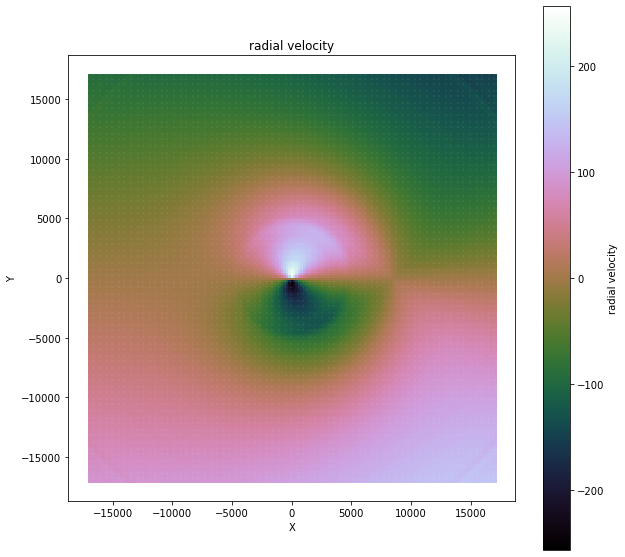

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

# This flag can be used to clearly separate the positive and negative velocities. This will set any value in +/- `separate` to NaN.
separate = 0

# Although the variable is called radius, the plot will be a square with side length 2*radius.
radius = 17000
voxel_size = 200
num = int(2*radius/voxel_size + 1)

# These are simply flags to change what is plotted
# value = 'relative sigma'
# value = 'relative phi'
value = 'radial velocity'

title = value

# Create the X,Y coordinates
arr = np.linspace(-radius, radius, num=num)
x,y = np.meshgrid(arr,arr)
x = x.flatten()
y = y.flatten()

# Loop through the coordinates and append to the list of velocities
velocity = []
for X,Y in zip(x,y):
  velocity.append(calculateVelocity(X,Y,0,value=value,voxel_size=voxel_size))

# Adjust the velocity list according to the `separate` flag
velocity = np.asarray(velocity)
if separate:
  velocity[(velocity<separate)&(velocity>-separate)] = np.nan

# A simple scatter plot is used to display the voxel velocities. You may optionally plot the location of the Sun.
fig,ax = plt.subplots(1,1,figsize=(10,10))
# ax.scatter(rGalEarth,0,c='k')
cm = ax.scatter(x, y, c=velocity, cmap='cubehelix', marker='s', s=4, alpha=1)
plt.colorbar(cm,spacing='proportional',label=title)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(title)
ax.set_aspect('equal')

plt.show()

This cell will plot the relative radial velocity for *with* averaging=3 (9 subvoxel points).

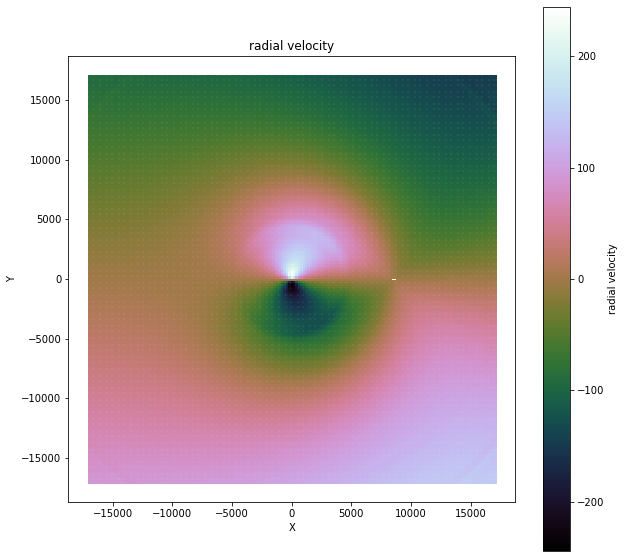

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

# This flag can be used to clearly separate the positive and negative velocities. This will set any value in +/- `separate` to NaN.
separate = 0

# Although the variable is called radius, the plot will be a square with side length 2*radius.
radius = 17000
voxel_size = 200
num = int(2*radius/voxel_size + 1)

# These are simply flags to change what is plotted
# value = 'relative sigma'
# value = 'relative phi'
value = 'radial velocity'

title = value

# Create the X,Y coordinates
arr = np.linspace(-radius, radius, num=num)
x,y = np.meshgrid(arr,arr)
x = x.flatten()
y = y.flatten()

# Loop through the coordinates and append to the list of velocities
velocity = []
for X,Y in zip(x,y):
  velocity.append(calculateVelocity(X,Y,0,value=value,voxel_size=voxel_size,average=3))

# Adjust the velocity list according to the `separate` flag
velocity = np.asarray(velocity)
if separate:
  velocity[(velocity<separate)&(velocity>-separate)] = np.nan

# A simple scatter plot is used to display the voxel velocities. You may optionally plot the location of the Sun.
fig,ax = plt.subplots(1,1,figsize=(10,10))
# ax.scatter(rGalEarth,0,c='k')
cm = ax.scatter(x, y, c=velocity, cmap='cubehelix', marker='s', s=4, alpha=1)
plt.colorbar(cm,spacing='proportional',label=title)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(title)
ax.set_aspect('equal')

plt.show()

In [4]:
r1 = 500
r2 = rGalEarth-r1
print(r1, r2, rGalEarth)
sig = (r1**2+r2**2-rGalEarth**2)/2/r1/r2
sig = (r1**2+r2**2-rGalEarth**2)/(2*r1*r2)
np.arccos(sig)

500 8000 8500


3.141592653589793

In [5]:
calculateVelocity(100, 0, 0, value='', verbose=True)

velocity: 233.0
R_pol: 100.0 8400.0
phi, sigma 0.0 3.141592653589793
Earth velocity: 227.62


0.0

In [6]:
np.arctan2(-0.0002,-1)

-3.14139265359246

This is a cell to create the image I want to describe how this procedure.

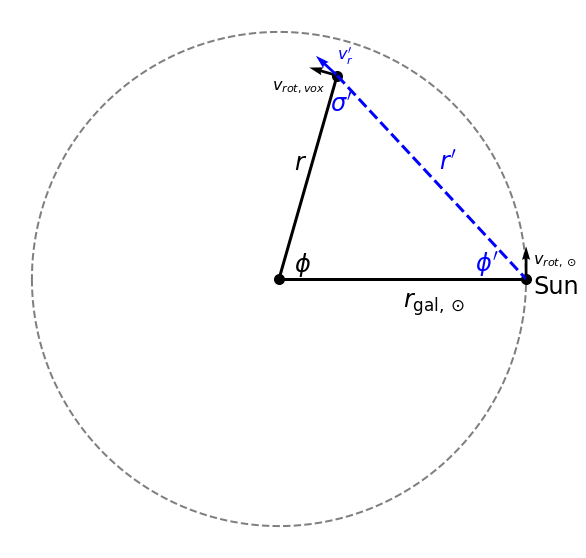

In [7]:
# Define the positions used
voxel = np.array([2000,7000,0])
Earth = np.array([rGalEarth,0,0])
voxel_relative = np.array([Earth[0]-voxel[0],voxel[1]])
center = np.array([0,0,0])
vel_voxel = 230
vel_Earth = 260

# Calculate the necessary variables
rPol = np.sqrt(voxel[0]**2+voxel[1]**2)
relativeRpol = np.sqrt(voxel_relative[0]**2+voxel_relative[1]**2)
phi = np.arctan2(voxel[1], voxel[0])
relativePhi = np.arctan2(voxel_relative[1], voxel_relative[0])

# Create some arrays for the plot
angles = np.linspace(-np.pi, np.pi, num=1000)
r_coord = np.linspace(center, voxel, num=1000)
relativeR_coord = np.linspace(voxel, Earth, num=1000)
rGal_coord = np.linspace(center, Earth, num=1000)

# Setup the figure
fig,ax = plt.subplots(1,1,figsize=(10,10))
#triangle sides
ax.plot(r_coord[:,0], r_coord[:,1], ls='-', lw=3, c='k')
ax.plot(rGal_coord[:,0], rGal_coord[:,1], ls='-', lw=3, c='k')
ax.plot(relativeR_coord[:,0], relativeR_coord[:,1], ls='--', lw=3, c='b')
#orbit
ax.plot(rGalEarth*np.cos(angles), rGalEarth*np.sin(angles), ls='--', lw=2, c='k', alpha=0.5)
#vertices
ax.scatter(center[0], center[1], marker='o', s=100, c='k')
ax.scatter(voxel[0], voxel[1], marker='o', s=100, c='k')
ax.scatter(Earth[0], Earth[1], marker='o', s=100, c='k')
#velocities
u,v = [-vel_voxel*np.sin(phi),-vel_voxel*np.sin(relativePhi),0], [vel_voxel*np.cos(phi),vel_voxel*np.cos(relativePhi),vel_Earth]
color = ['k', 'b', 'k']
q1 = ax.quiver([voxel[0],voxel[0],Earth[0]], [voxel[1],voxel[1],Earth[1]], u, v, color=color, width=0.005)
# q1 = ax.quiver(voxel[0], voxel[1], -vel_voxel*np.sin(phi), vel_voxel*np.cos(phi), width=0.005)
# q2 = ax.quiver(Earth[0], Earth[1], 0, vel_Earth, width=0.005)
#text
offset = 250
ax.text(Earth[0]+offset, Earth[1]-2*offset, 'Sun', fontsize=24, c='k')
ax.text(Earth[0]/2, Earth[1]/2-4*offset, r'$r_{\mathrm{gal},\odot}$', fontsize=24, c='k')
ax.text(voxel[0]/2-2*offset, voxel[1]/2+offset, r'$r$', fontsize=24, c='k')
ax.text(voxel[0]+voxel_relative[0]/2+offset, voxel[1]/2+offset, r"$r'$", fontsize=24, c='b')
ax.text(2*offset, offset, r'$\phi$', fontsize=24, c='k')
ax.text(voxel[0]-1*offset, voxel[1]-5*offset, r"$\sigma'$", fontsize=24, c='b')
ax.text(Earth[0]-7*offset, Earth[1]+offset, r"$\phi'$", fontsize=24, c='b')
ax.text(voxel[0]-0*offset, voxel[1]+2*offset, r"$v_r'$", fontsize=16, c='b')
ax.text(voxel[0]-9*offset, voxel[1]-2*offset, r"$v_{rot,vox}$", fontsize=16, c='k')
ax.text(Earth[0]+1*offset, Earth[1]+2*offset, r"$v_{rot,\odot}$", fontsize=16, c='k')
#rescale and remove axes
ax.set_axis_off()
ax.set_aspect('equal')